# Titanic Dataset Survivor Prediction
The Titanic dataset is one of the basic datasets at kaggle which purposes to predict survivors from Titanic disaster. Also, it has low data size, but gives high oppurtunity for feature engineering. At first, each feature will be handled one by one and then machine learning models will be trained and compared. At last, selected model with processed data will be submitted.

There are 3 sections at total which are:
1. EDA & Feature Engineering
2. Machine learning Model Selection
3. Submission

Note: Additionally, I generated more features than I used, but I did not want to remove them because submission succes percentage were so close. That is why, not used lines are commented 

## 1. EDA & Feature Engineering

Required packages and are generally:
* Pandas -> data processing

* Numpy -> data processing

* Missingno -> visualization

* Seaborn -> visualization

* Matplotlib -> visualization

* Sklearn -> machine learning models & model selection

* Catboost, XGBoost, LightGBM -> machine learning models

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import  accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')


After importing libraries train & test data are concated to process features at same time. Indexes are resetted to resolve same index confusion.

In [2]:
df_train = pd.read_csv("datasets/train.csv")
df_test = pd.read_csv("datasets/test.csv")

train_bound = len(df_train)

df = pd.concat([df_train, df_test], axis=0)
df.reset_index(inplace=True, drop=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,1309.0,655.000000,378.020061,1.00,328.0000,655.0000,982.000,1309.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.000,1.0000
Pclass,1309.0,2.294882,0.837836,1.00,2.0000,3.0000,3.000,3.0000
Age,1046.0,29.881138,14.413493,0.17,21.0000,28.0000,39.000,80.0000
SibSp,1309.0,0.498854,1.041658,0.00,0.0000,0.0000,1.000,8.0000
Parch,1309.0,0.385027,0.865560,0.00,0.0000,0.0000,0.000,9.0000
Fare,1308.0,33.295479,51.758668,0.00,7.8958,14.4542,31.275,512.3292


By using missingno library missing values are visualized. Age feature will be imputed by kNNImputer and Cabin will be filled by using other relevant features.

Since output feature is Survived column it is missing all survived values which included by test data set. 

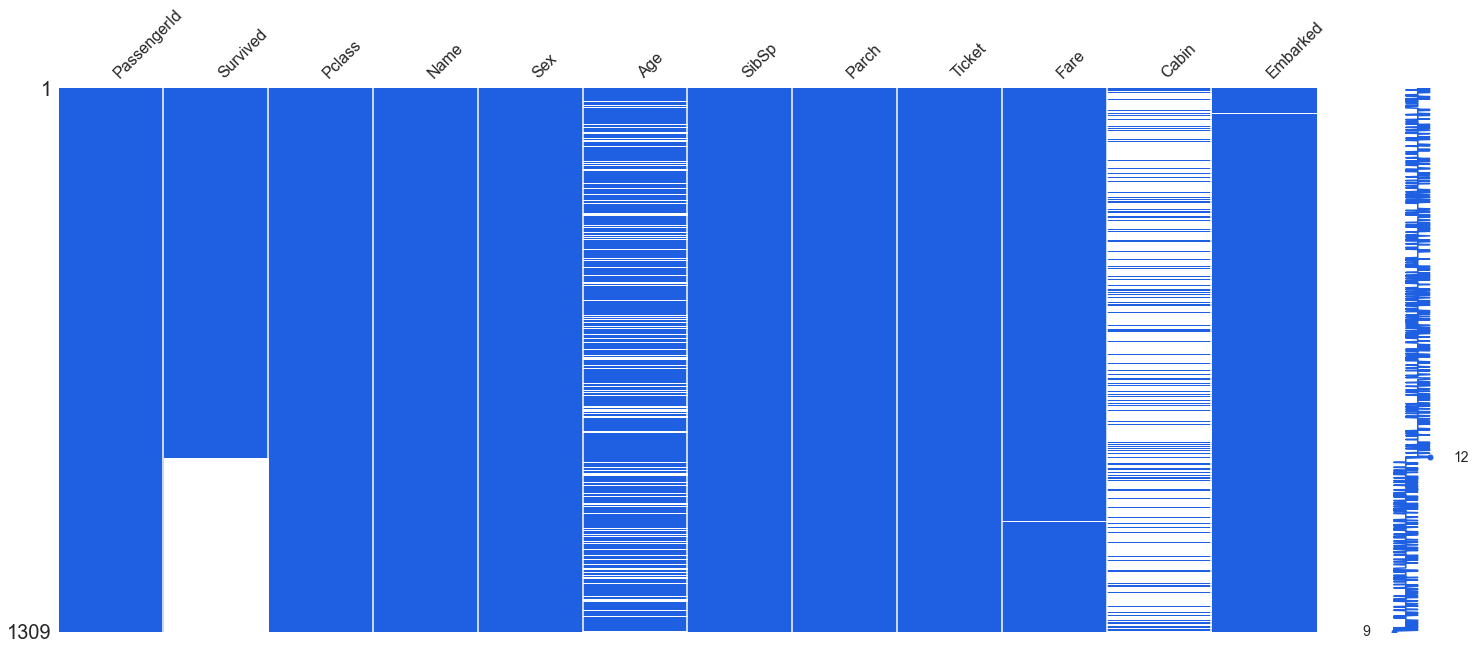

In [4]:
msno.matrix(df, color=(30/255, 96/255, 225/255));

In [5]:
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

## 1.1 Sex Feature

Most of these survivors are female, but men count approximately doubles count of women. From this, we can assume that women were given priority during the rescue. By looking at the numbers of the genders and their average survival rate, we can already predict that gender data will be a very important feature for Survived prediction.

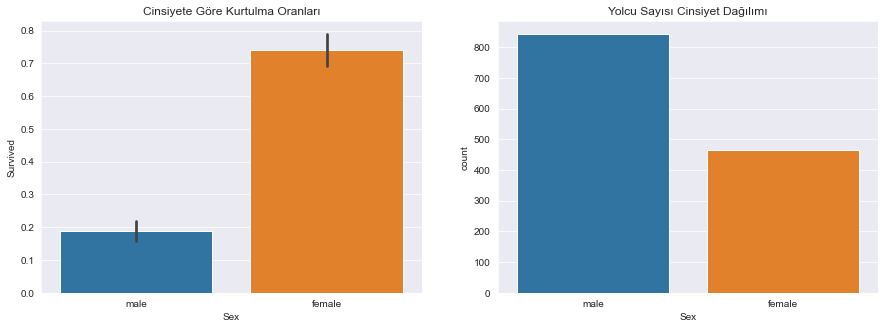

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(ax=axes[0], x="Sex", y="Survived", data=df);
axes[0].set_title("Cinsiyete Göre Kurtulma Oranları")


sns.countplot(ax=axes[1], x="Sex", data=df);
axes[1].set_title("Yolcu Sayısı Cinsiyet Dağılımı");

In [7]:
gender_dictionary = {"female":1 , "male": 0}
df.Sex = df.Sex.map(gender_dictionary)

## 1.2 Embarked Feature

Embarked indicates from which port the passengers boarded the ship. These ports are:
* S → Southampton
* Q → Queenstown
* C → Cherbourg

The embarked feature has 2 missing data and we fill them with the most frequent S class and visualize their frequencies in the data set.

Embarked has 2 NaN values.


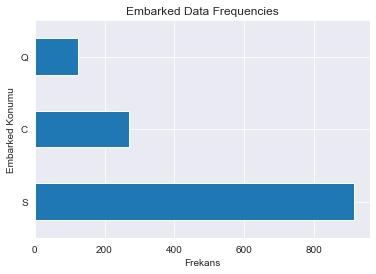

In [8]:
print("Embarked has", df.Embarked.isnull().sum(), "NaN values.")
df["Embarked"].value_counts().plot.barh().set_title("Embarked Data Frequencies");
plt.xlabel("Frekans");
plt.ylabel("Embarked Konumu");

As can be seen from the chart below, the highest survival rate is for those who embark from the port of Cherbourg, although there is not much difference. The main reason for this may be due to the fact that the passengers boarding from that port are predominantly upper class or women.

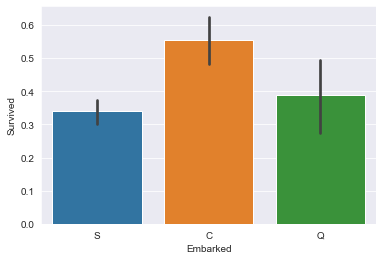

In [9]:
df.Embarked.fillna('S', inplace=True)
sns.barplot(x="Embarked", y= "Survived", data=df);

When we visualize the data numerically using groupby, it seems that the reason for the low survival rate for those boarding from Southampton port is that predominantly 3rd class men boarded from that port. The reason for the high survival rate of the port of Cherbourg is that most men are from the 1st class and the number of women is more than men.

In [10]:
df.groupby(["Embarked", "Pclass", "Sex"]).aggregate(["count", "mean"])[["Survived", "Fare"]]

Survived            Fare            
                       count      mean count        mean
Embarked Pclass Sex                                     
C        1      0         42  0.404762    70   94.622560
                1         43  0.976744    71  118.895949
         2      0         10  0.200000    17   20.904406
                1          7  1.000000    11   27.003791
         3      0         43  0.232558    70    9.775901
                1         23  0.652174    31   13.834545
Q        1      0          1  0.000000     1   90.000000
                1          1  1.000000     2   90.000000
         2      0          1  0.000000     5   11.489160
                1          2  1.000000     2   12.350000
         3      0         39  0.076923    57   10.979167
                1         33  0.727273    56    9.791968
S        1      0         79  0.354430   108   53.670756
                1         50  0.960000    71  100.475648
         2      0         97  0.154639   149   20.073322
                1         67  0.910448    93   23.023118
         3      0        265  0.128302   365   13.145977
                1         88  0.375000   129   18.083851

##  1.3 Cabin Feature

This feature has most NaN values at total. At first NaN values are filled with N class to process. Then, because of not NaN values are unique and their first letter represents their belonged deck only first characters of the cabin data are going to be considered.

In [11]:
df["Cabin"].fillna('N', inplace=True)

df["Cabin_Category"] = df["Cabin"].str[0]

By checking Cabin_Category distribution with respect to their Pclass, Fare  and Survive these variables will be grouped as A, BC, DE, FG and finally N. T has 1 value so it will be altered to most closest cabin category which is A.

In [12]:
df.groupby(["Cabin_Category", "Pclass"])[["Survived", "Fare"]].aggregate(["count", "mean","std"])

Survived                      Fare              \
                         count      mean       std count        mean   
Cabin_Category Pclass                                                  
A              1            15  0.466667  0.516398    22   41.244314   
B              1            47  0.744681  0.440755    65  122.383078   
C              1            59  0.593220  0.495450    94  107.926598   
D              1            29  0.758621  0.435494    40   58.919065   
               2             4  0.750000  0.500000     6   13.595833   
E              1            25  0.720000  0.458258    34   63.464706   
               2             4  0.750000  0.500000     4   11.587500   
               3             3  1.000000  0.000000     3   11.000000   
F              2             8  0.875000  0.353553    13   23.423077   
               3             5  0.200000  0.447214     8    9.395837   
G              3             4  0.500000  0.577350     5   14.205000   
N              1            40  0.475000  0.505736    67   70.268157   
               2           168  0.440476  0.497928   254   21.394537   
               3           479  0.235908  0.425009   692   13.351522   
T              1             1  0.000000       NaN     1   35.500000   

                                   
                              std  
Cabin_Category Pclass              
A              1        20.140358  
B              1       115.312993  
C              1        72.912034  
D              1        25.256615  
               2         0.829640  
E              1        35.322753  
               2         1.283469  
               3         2.554775  
F              2        12.306580  
               3         5.241519  
G              3         3.416419  
N              1        80.114953  
               2        13.843615  
               3        11.602014  
T              1              NaN

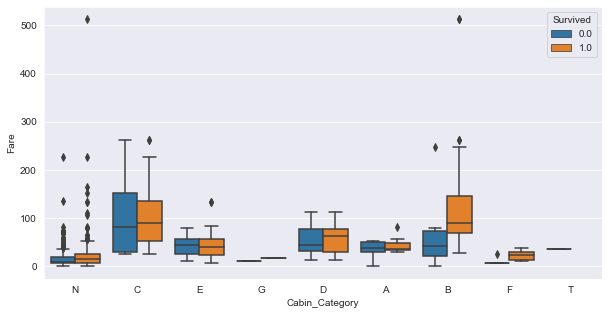

In [13]:
plt.figure(figsize=(10,5))
sns.boxplot(x="Cabin_Category", y="Fare", hue="Survived", data=df);

When I checked the passengers with the same ticket number, I noticed that some passengers belong to the N cabin category even though they have the same ticket number. Therefore, I grouped the passengers by ticket and assigned the same cabin categories to the same groups.

In [14]:
ticket2cabin_dict = df[df.Cabin != 'N'][["Ticket", "Cabin_Category"]].drop_duplicates().set_index("Ticket").to_dict()["Cabin_Category"]
df["Cabin_Category"] = df.apply(lambda row: ticket2cabin_dict.get(row.Ticket, 'N'), axis=1)
#ticket2cabin_dict

In [15]:
df.groupby(["Cabin_Category", "Pclass"])[["Survived","Fare"]].aggregate(["count", "mean"])

Survived            Fare            
                         count      mean count        mean
Cabin_Category Pclass                                     
A              1            17  0.470588    24   42.346004
B              1            48  0.750000    68  131.484438
C              1            66  0.621212   103  112.745390
D              1            29  0.758621    40   58.919065
               2             4  0.750000     6   13.595833
E              1            24  0.708333    33   63.662752
               2             5  0.600000     5   11.370000
               3             3  1.000000     3   11.000000
F              2             8  0.875000    13   23.423077
               3             6  0.333333    10   11.988330
G              3             4  0.500000     5   14.205000
N              1            31  0.387097    54   40.782404
               2           167  0.443114   253   21.437598
               3           478  0.234310   690   13.325416
T              1             1  0.000000     1   35.500000

As I said T class has 1 value and it will altered to most closest category. Then, similiar cabin category groups will be matched in theirselves. 
* To elaborate, A, B and C cabin categories have only 1st class passengers, yet A cabin category fare price is much lower other two.
* D has passengers from 1st, 2nd cabin category, but E has from 3rd class too. Even it was a difference 1st class passenger rate was dominant on both. Also their fare prices & survival rates  were similiar.
* F & G had both low data and they were a bit similiar on fare prices & survival rates on 3rd class. 

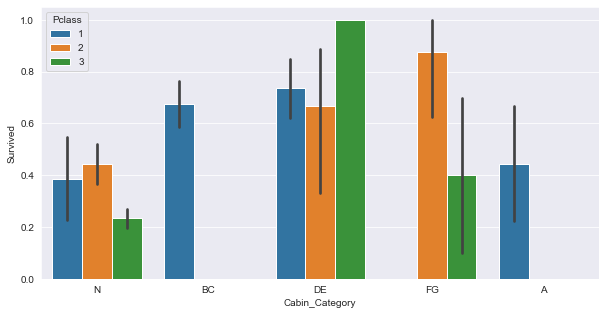

In [16]:
df["Cabin_Category"] = df["Cabin_Category"].apply(lambda x: 'A' if x=='T' else x)
df["Cabin_Category"] = df["Cabin_Category"].apply(lambda x: 'BC' if (x=='B') or (x=='C')
                                else ('DE' if x=='D' or x=='E'
                                     else('FG' if x=='F' or x=='G' else x)))
df.drop(columns=["Cabin"], axis=1, inplace=True)
plt.figure(figsize=(10,5))
sns.barplot(x="Cabin_Category", y="Survived", hue="Pclass", data=df);

Passengers who had D or E cabin categories survival rate were much higher than mainly at 3rd class. Maybe it is about to their cabin category location at the ship.

## 1.4 Name Feature
2 Main features are going to be obtained from the name feature. These are passengers title and their surname. From their titles their status, age, survive relevant information can be obtained. From their surnames they can be grouped to match missing Cabin features. 
## 1.4.1 Title Feature

Title is obtain by getting characters between first comma and point. Then, string is cut from starting 1st index and finally spaces are deleted by strip module. 

After obtaining title, by visualizing this feature numerically it seems there a lot of unique classes. In order to avoid it common ones will be grouped in theirselves and rest will be categorized as other.


In [17]:
df["Title"] = df.Name.apply(lambda x: x[x.find(',') : x.find('.')][1:].strip())
df.groupby("Title").aggregate(["count", "mean"])[["Survived", "Age","Fare"]]

Survived             Age             Fare            
                count      mean count       mean count        mean
Title                                                             
Capt                1  0.000000     1  70.000000     1   71.000000
Col                 2  0.500000     4  54.000000     4   79.518750
Don                 1  0.000000     1  40.000000     1   27.720800
Dona                0       NaN     1  39.000000     1  108.900000
Dr                  7  0.428571     7  43.571429     8   53.254688
Jonkheer            1  0.000000     1  38.000000     1    0.000000
Lady                1  1.000000     1  48.000000     1   39.600000
Major               2  0.500000     2  48.500000     2   28.525000
Master             40  0.575000    53   5.482642    61   36.008195
Miss              182  0.697802   210  21.774238   260   42.684873
Mlle                2  1.000000     2  24.000000     2   59.402100
Mme                 1  1.000000     1  24.000000     1   69.300000
Mr                517  0.156673   581  32.252151   756   24.796185
Mrs               125  0.792000   170  36.994118   197   50.560723
Ms                  1  1.000000     1  28.000000     2   10.375000
Rev                 6  0.000000     8  41.250000     8   18.609375
Sir                 1  1.000000     1  49.000000     1   56.929200
the Countess        1  1.000000     1  33.000000     1   86.500000

What I have done while processing title is:
* Ms was representing woman at any martial status. Thus, converted to Miss.
* Mme & Mlle was representing Mademoiselle which shows unmarried woman. Hence, converted to Miss.
* Lady could be altered to Mrs or Ms, but I didnt want to lower more the survival rate of these unique titles.
* Mr, Mrs, Miss, Master title has enough data to represent their importancy. 
* Unique titles will be categorized as uncommon. These titles are: the Countess, Sir, Rev, Major, Lady, Jonkheer, Dr, Dona, Don, Col, Capt
* At final 5 unique title categories were remeaning. These were, Mr, Mrs, Miss, Master and Uncommon.

In [18]:
df["Title"] = df["Title"].apply(lambda x: "Miss" if x == 'Ms'or x == 'Mme' or x=='Mlle' else x)
df["Title"] = df["Title"].apply(lambda x: "Other" if x != "Miss" and x != "Master" and x!= "Mr" and x!= "Mrs" else x)

It was clear to estimate Mr title survive rate would be so low. Miss and Mrs categories have high survive rate because both of them represents woman, but Mrs title survive rate 10% more than the Miss title. It could mean married or widowed woman prioritized while saving lifes or it could mean husbands of married women more strived to save their wifes.

Master title was given who age between 0.33 and 14.5. It means it is a title that given only to children.

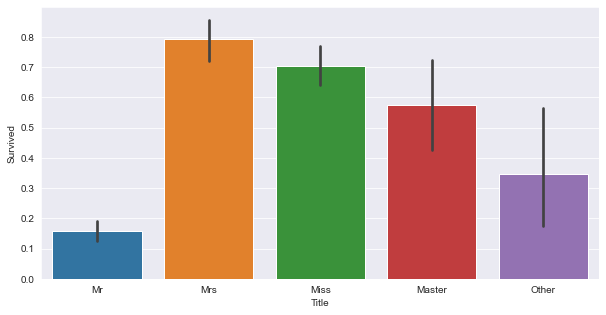

In [19]:
plt.figure(figsize=(10,5))
sns.barplot(x="Title", y="Survived", data=df);

## 1.4.2 Surname Processing

Surnames obtained from Names feature are assigned to new Surnames feature. To achieve it, names are splitted by comas which generates lists, and gathered first elements from litsts. Then, passengers who have same surname are grouped.
surname2cabin dictionary are produced. 


In [20]:
df["Surname"] = df.Name.apply(lambda x: x.lower().split(",")[0])
surname2cabin_dict = df.groupby("Surname")["Cabin_Category"].apply(list).to_dict()
for key in surname2cabin_dict:
    l = surname2cabin_dict[key]
    if "N" in l:
        l.remove("N")
    if len(l)>0:
        freq_char = max(set(l), key=l.count)
    else:
        freq_char = "N"
    surname2cabin_dict[key] = freq_char

df.Cabin_Category = df.apply(lambda x: surname2cabin_dict.get(x.Surname, "N") if x.Cabin_Category == "N" else x.Cabin_Category, axis=1)
df.groupby("Cabin_Category").describe()[["Survived"]]

Survived                                             
                  count      mean       std  min  25%  50%  75%  max
Cabin_Category                                                      
A                  20.0  0.450000  0.510418  0.0  0.0  0.0  1.0  1.0
BC                121.0  0.644628  0.480616  0.0  0.0  1.0  1.0  1.0
DE                 68.0  0.720588  0.452046  0.0  0.0  1.0  1.0  1.0
FG                 19.0  0.578947  0.507257  0.0  0.0  1.0  1.0  1.0
N                 663.0  0.294118  0.455989  0.0  0.0  0.0  1.0  1.0

## 1.5 Parch & SibSp Feature

Parch indicates the number of parents in the family, while SibSp indicates the number of spouses and siblings. In order to determine the number of people in the family and to make generalizations, we combine these two columns to create a new feature that indicates how many people the family consists of. Thus, we can see the probability of surviving people according to the number of groups in the family.

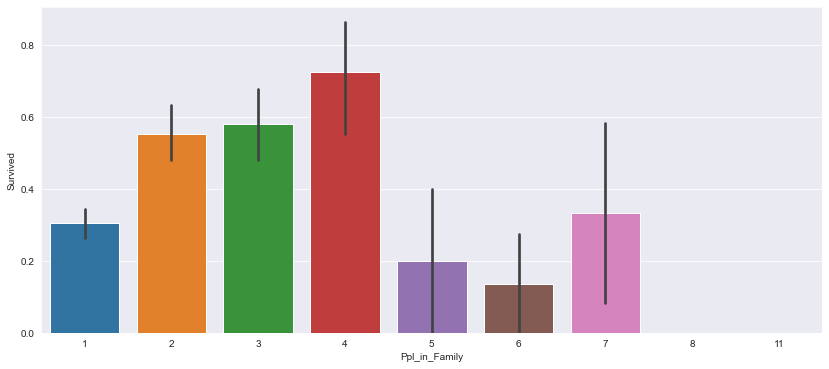

In [21]:
df["Ppl_in_Family"] = df["Parch"] + df["SibSp"] + 1
df.drop(["Parch","SibSp"], axis=1, inplace=True)
plt.figure(figsize=(14,6))
sns.barplot(x="Ppl_in_Family", y="Survived", data=df);

## 1.6 Ticket Feature

Passengers who have same ticket means they bought these tickets as a group. It shows these groups may not be the family but friends. This feature shows us again if the passenger is alone or with a high group s/he has low survival rate.

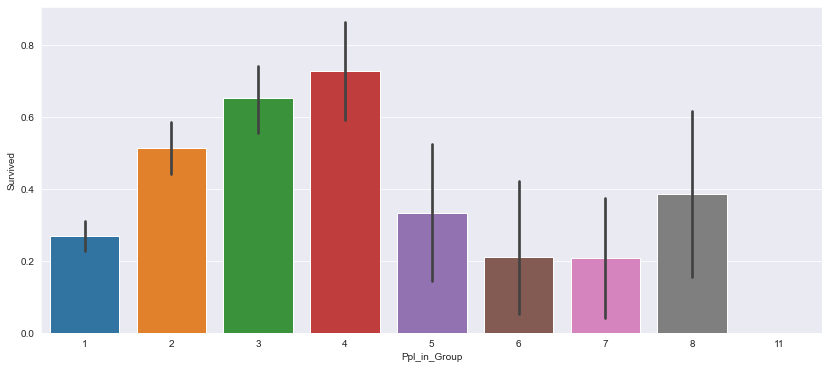

In [22]:
ppl_group_dict = df["Ticket"].value_counts().to_dict()
df["Ppl_in_Group"] = df.Ticket.apply(lambda x: ppl_group_dict.get(x, 1))
plt.figure(figsize=(14,6))
sns.barplot(x="Ppl_in_Group", y="Survived", data=df);

Because of machine learning model was biased to passenger is survived if the passenger is child or female, groups which have female or child are filtered. Then, their survival ratios are obtained. Lastly, their ratios switched to int from float since machine learning model was required to predict more deaths. This feature was a bit overfitting, but it was overfitting submission data well too. That is why, it is used.

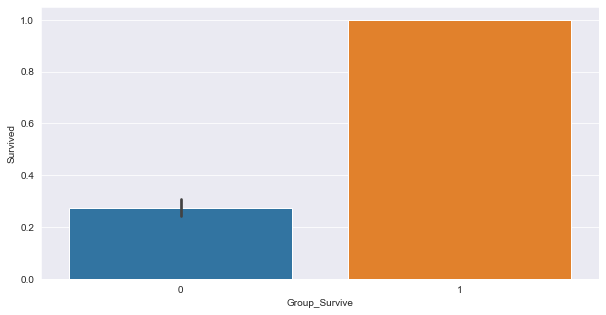

In [23]:
df['Ticket_Group_idx'] = df.Ticket.apply(lambda x: 0 if len(df.loc[df.Ticket == x, 'PassengerId'])==0
                                         else df.loc[df.Ticket == x, 'PassengerId'].min())


group_fem_child = df.loc[((df.Sex == 1) | (df.Title == "Master")) & (df['Ticket_Group_idx'] > 0), 'Ticket_Group_idx'].value_counts()
group_fem_child = group_fem_child[group_fem_child >= 2]



df['Got_Fem_Child'] = 0
df.loc[((df.Sex == 1) | (df.Title == "Master")) & (df['Ticket_Group_idx'] > 0)
       & (df["Ticket_Group_idx"].isin(group_fem_child.index)), 'Got_Fem_Child'] = 1

df['Group_Survive'] = df.loc[df['Got_Fem_Child'] == 1].groupby('Ticket_Group_idx')['Survived'].transform(lambda x: x.mean(skipna=True))

df.loc[df.Group_Survive.isnull(), 'Group_Survive'] = 0
df['Group_Survive'] = df['Group_Survive'].astype(int)

df.drop(["Got_Fem_Child", "Ticket_Group_idx"], axis=1, inplace=True)
plt.figure(figsize=(10,5))
sns.barplot(x="Group_Survive", y="Survived", data=df);

Additionally, tickets were starting with different letters or numbers. Thereby, at first they are grouped by letters and numbers. Yet, there were a lot of unique tickets with encoded different letters. So, I grouped them and unique tickets which have value count below 15 classified as other.

In [24]:
df["Ticket"] = df.Ticket.apply(lambda x: x.replace("/","").replace(".", "").split(" ")[0] if not x.isdigit() else "Numeric")


In [25]:
def ticket_matcher(ticket):
    if ticket == "SOTONO2":
        ticket = "SOTONOQ"
    
    elif ticket == "A4":
        ticket = "A5"
    
    elif ticket == "STONO2" or ticket == "STONOQ":
        ticket = "STONO"
        
    return ticket
df["Ticket"] = df.Ticket.apply(lambda x: x.replace("/","").replace(".", "").split(" ")[0] if not x.isdigit() else "Numeric")
df["Ticket"] = df.Ticket.apply(ticket_matcher)

df["Ticket"] = df.Ticket.apply(lambda x: "Other" if len(df[df.Ticket == x]) < 15 else x)
df.groupby(["Ticket","Pclass"]).aggregate(["count", "mean"])[["Survived", "Fare"]]

Survived            Fare            
                  count      mean count        mean
Ticket  Pclass                                     
A5      3            28  0.071429    38   10.431139
CA      2            19  0.473684    33   20.211742
        3            22  0.227273    35   39.754286
Numeric 1           152  0.631579   224   72.537204
        2           127  0.480315   184   19.794995
        3           382  0.253927   548   12.219152
Other   1             4  0.250000     7   56.298814
        2            35  0.457143    55   27.361289
        3            17  0.294118    28    8.988093
PC      1            60  0.650000    92  126.336726
SOTONOQ 3            17  0.117647    27    8.212963
STONO   3            18  0.444444    22    8.542045
WC      2             3  0.333333     5   10.500000
        3             7  0.000000    10   27.322500

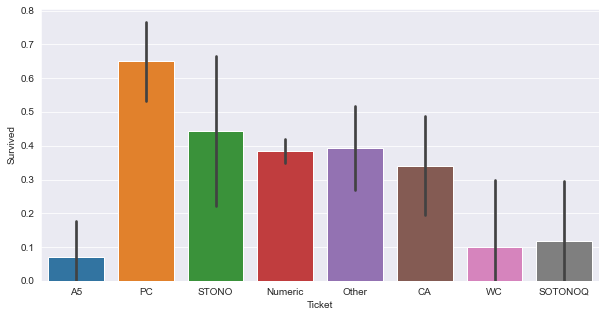

In [26]:
plt.figure(figsize=(10,5))
sns.barplot(x="Ticket", y="Survived", data=df);

## 1.7 Fare Process

At first, qcut is used to obtain distributions at Fare feature. However, there were a lot of passenger who paid 0 to Fare.
For this reason, at first I used qcut to determine distributions, combined similiar groups and distributed 0-1 Fare paid passengers too. Neverthless, maybe the reason of grouping different fare values succes rate is dropped. Because of I will be using decision trees at modeling Fare feature is not processed.

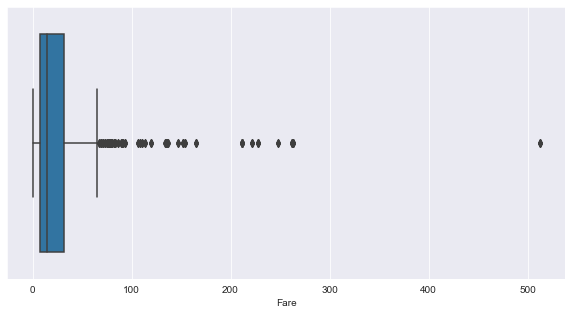

In [27]:
plt.figure(figsize=(10,5))
sns.boxplot(x="Fare", data=df);

In [28]:
Q1 = df.Fare.quantile(0.25)
Q3 = df.Fare.quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5*IQR
lower_bound = Q1 - 1.5*IQR

df.Fare = df.Fare.apply(lambda x: upper_bound if x > upper_bound else x) 
df.Fare = df.Fare.apply(lambda x: lower_bound if x < lower_bound else x)

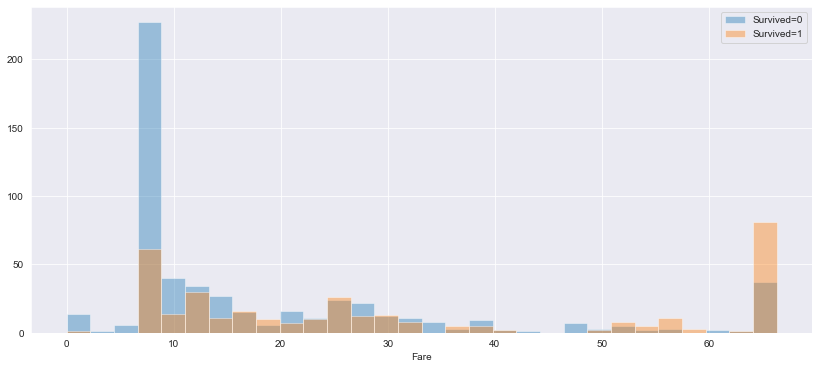

In [29]:
plt.figure(figsize=(14,6))
sns.distplot(df[(df.Survived==0)].Fare, label="Survived=0",kde=False, bins=30)
sns.distplot(df[(df.Survived==1)].Fare, label="Survived=1", kde=False, bins=30)
plt.legend();

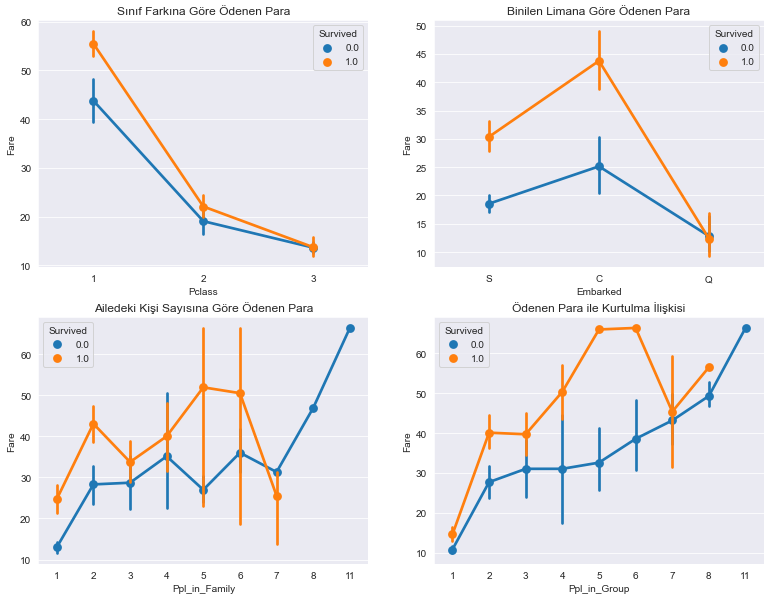

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(13, 10))
sns.pointplot(ax=axes[0,0], x="Pclass",y="Fare",hue="Survived", data=df)
axes[0,0].set_title("Fare with Respect to Pclass")

sns.pointplot(ax=axes[0,1], x="Embarked",y="Fare", hue="Survived",data=df)
axes[0,1].set_title("Fare with Respect to Embarked")

sns.pointplot(ax=axes[1,0], x="Ppl_in_Family",y="Fare", hue="Survived",data=df)
axes[1,0].set_title("Fare with Respect to Ppl_in_Family")

sns.pointplot(ax=axes[1,1], x="Ppl_in_Group",y="Fare", hue="Survived",data=df)
axes[1,1].set_title("Fare with Respect to Ppl_in_Group")
plt.title("Ödenen Para ile Kurtulma İlişkisi");

In [31]:
#df["Fare"] = pd.cut(df["Fare"], [df.Fare.min()-0.1, 1, 10.5, 26.955,  41.579, 78.051, df.Fare.max()])
#df.groupby("Fare").mean()[["Survived"]]
#df = pd.get_dummies(df, columns=["Fare"])

## 1.8 Pclass Process

This feature is ordinal categorical data. It shows the class of the passenger which is correlated with Fare feature. Yet, instead of keeping the categorical ordinal as same, categorizing it increased the overall succes at train & test side. In my opinion, reason of it is, even there is an negative correlation between Pclass and Survived features, it does not mean 1st class is 3 times better than 3rd class. That being the case, categorizing them was more revealing their meanings.

In [32]:
print(f"Pclass ve Survived arasındaki korelasyon: {round(df.Pclass.corr(df.Survived),4)}")
print(f"Pclass ve Fare arasındaki korelasyon: {round(df.Pclass.corr(df.Fare),4)}")

df.groupby("Pclass").mean()[["Survived","Fare"]]

Pclass ve Survived arasındaki korelasyon: -0.3385
Pclass ve Fare arasındaki korelasyon: -0.726


,Survived,Fare
Pclass,,
1,0.629630,51.293955
2,0.472826,20.998354
3,0.242363,13.253075


As estimated, Pclass feature is mostly related with Fare feature. Neverthless, Embarked feature which represents where the passenger embarked to ship, age, cabin category are other factors that affect Fare of the Pclass. For this reason, these other factors looks like to be considered while determining person Pclass. 

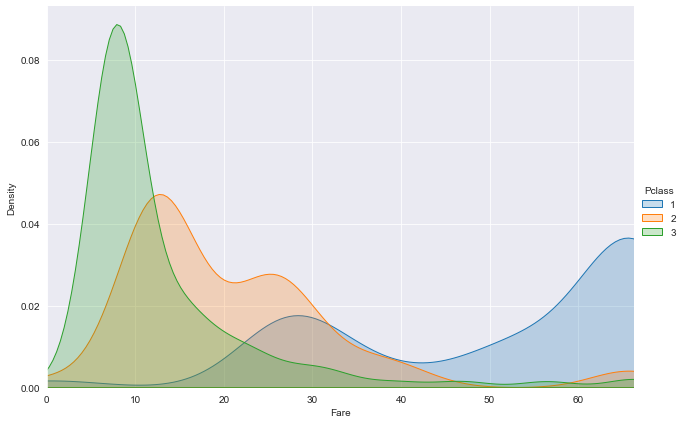

In [33]:
(sns.
    FacetGrid(df,
             hue="Pclass",
             height=6,
              aspect=1.5,
             xlim=(df.Fare.min(), df.Fare.max())
             )
.map(sns.kdeplot, "Fare", shade=True)
.add_legend());

## 1.9 OHE & Sparing

In order to fill missing values Survived and PassengerId they are backed up at df_spare dataframe. Name feature will be dropped since it is processed to obtain surnames and titles.  Survived and PassengerId features are dropped to fill missing values. After filling and processing Age feature they will be added back to data set since they are required at traning and submission.

In [34]:
df["Ppl_in_Group"] = pd.cut(df["Ppl_in_Group"], [0, 1, 2, 3, 4, 5, df.Ppl_in_Group.max()])
df["Ppl_in_Family"] = pd.cut(df["Ppl_in_Family"], [0, 1, 2, 3, 4,5, 11])

df = pd.get_dummies(df, columns=["Title","Ppl_in_Family", "Ppl_in_Group", "Pclass","Ticket","Cabin_Category","Embarked"])
df_spare = df[["PassengerId","Survived"]]
df.drop(["Name","Survived", "PassengerId","Surname"], axis=1, inplace=True)

## 1.10 Filling Missing Values

Age feature is missing 263 values. In order to fil it KNNImputer is going to be used. Meanwhile, Fare feature has 1 missing value too, so it will be imputed too. Reason of not using mean to missing values is to generalize the data more properly.

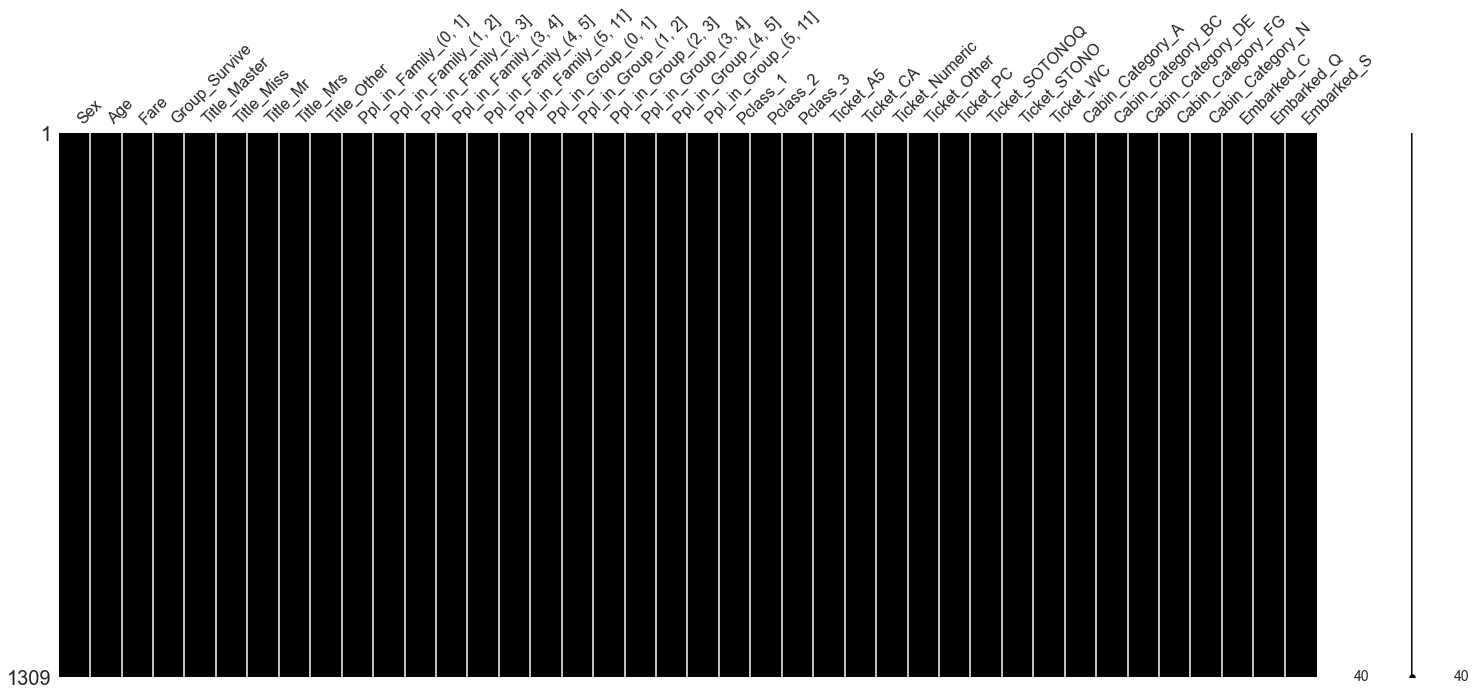

In [35]:
# So to impute remaining age values knn imputing method is used.
col_names = df.columns
df2numpy = df.to_numpy()
knn_imputer = KNNImputer(n_neighbors=3)
df2numpy = knn_imputer.fit_transform(df2numpy)
df = pd.DataFrame(df2numpy, columns=col_names)
# So no missing value is left.
msno.matrix(df, color=(0., 0., 0.));

## 1.11 Age Process

Finally, the Age, Fare, and Survived features are combined to be visualized in the df_viz data frame. The discrete values of the age data are again suppressed by the interquartile ranges. When we look at the age distribution between survivors and non-survivors, we can see that the survival rate of children is particularly high. Our chart concentrates on this range, as most of the boarders are in the 18-40 age range.

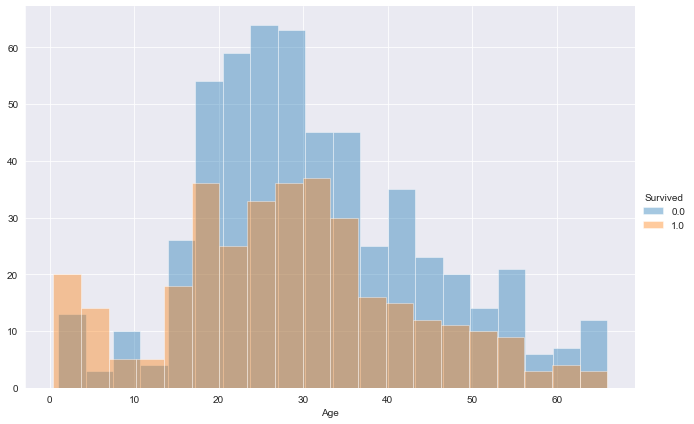

In [36]:
Q1 = df.Age.quantile(0.25)
Q3 = df.Age.quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5*IQR
lower_bound = Q1 - 1.5*IQR

df.Age = df.Age.apply(lambda x: upper_bound if x > upper_bound else x)
df.Age = df.Age.apply(lambda x: lower_bound if x < lower_bound else x)

df_viz = pd.concat([df[["Age", "Fare"]], df_spare[["Survived"]]], axis=1)

(sns.
    FacetGrid(df_viz.iloc[:train_bound,:],
             hue="Survived",
             height=6,
             aspect=1.5
             )
.map(sns.distplot, "Age",kde=False, bins=20)
.add_legend());

In [37]:
"""
group_age_dict = df.groupby("Surname").mean()["Age"].to_dict()
df["Group_Age"] = df.Surname.apply(lambda x: group_age_dict.get(x))

plt.figure(figsize=(14,6))
sns.distplot(df[(df.Survived==0) & (df.Group_Age < 9.6)].Group_Age, label="Survived=0",kde=False, bins=30)
sns.distplot(df[(df.Survived==1) & (df.Group_Age < 9.6)].Group_Age, label="Survived=1", kde=False, bins=30)
plt.legend()
""";

In [38]:
"""
plt.figure(figsize=(14,6))
sns.distplot(df[(df.Survived==0)].Group_Age, label="Survived=0",kde=False, bins=30)
sns.distplot(df[(df.Survived==1)].Group_Age, label="Survived=1", kde=False, bins=30)
plt.legend()""";

When we visualize the age data with Fare and Survived, we can notice that although the number of deaths is high, black dots are dominant and appear at every point, but red dots, i.e. survivors, are those who pay more at most ages.

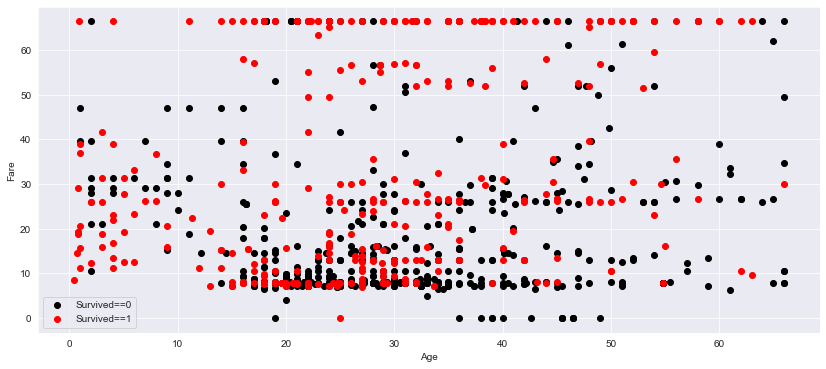

In [39]:
plt.figure(figsize=(14,6))
plt.scatter(df_viz[df_viz.Survived==0].Age[:train_bound], df_viz[df_viz.Survived==0].Fare[:train_bound], color="k", label="Survived==0")
plt.scatter(df_viz[df_viz.Survived==1].Age[:train_bound], df_viz[df_viz.Survived==1].Fare[:train_bound], color="r", label="Survived==1")
plt.xlabel("Age")
plt.ylabel("Fare")
plt.legend();

## 1.11 Removing Outliers

At first, I was focused removing outliers which may affect the data a lot. On the other hand, it would mean losing knowledge on data. Because of I was going to use decision tree based models removing outliers was not required. Hence, I did not lose knowledge on data either.

In [40]:
lof = LocalOutlierFactor()
lof.fit(df)
df_scores = lof.negative_outlier_factor_
df_scores = np.sort(df_scores)
df_scores[:20]

array([-4.30143808, -3.7512189 , -3.14926281, -3.00816437, -2.93127621,
       -2.8997155 , -2.86001438, -2.842367  , -2.63501598, -2.63085417,
       -2.62889909, -2.61809837, -2.54617368, -2.45455283, -2.44501502,
       -2.44501502, -2.44319296, -2.44036104, -2.35445404, -2.33609264])

Finally, Survived & PassengerId features are added back to data set, final processed data is saved and correlation map of features is visualized by heatmap.

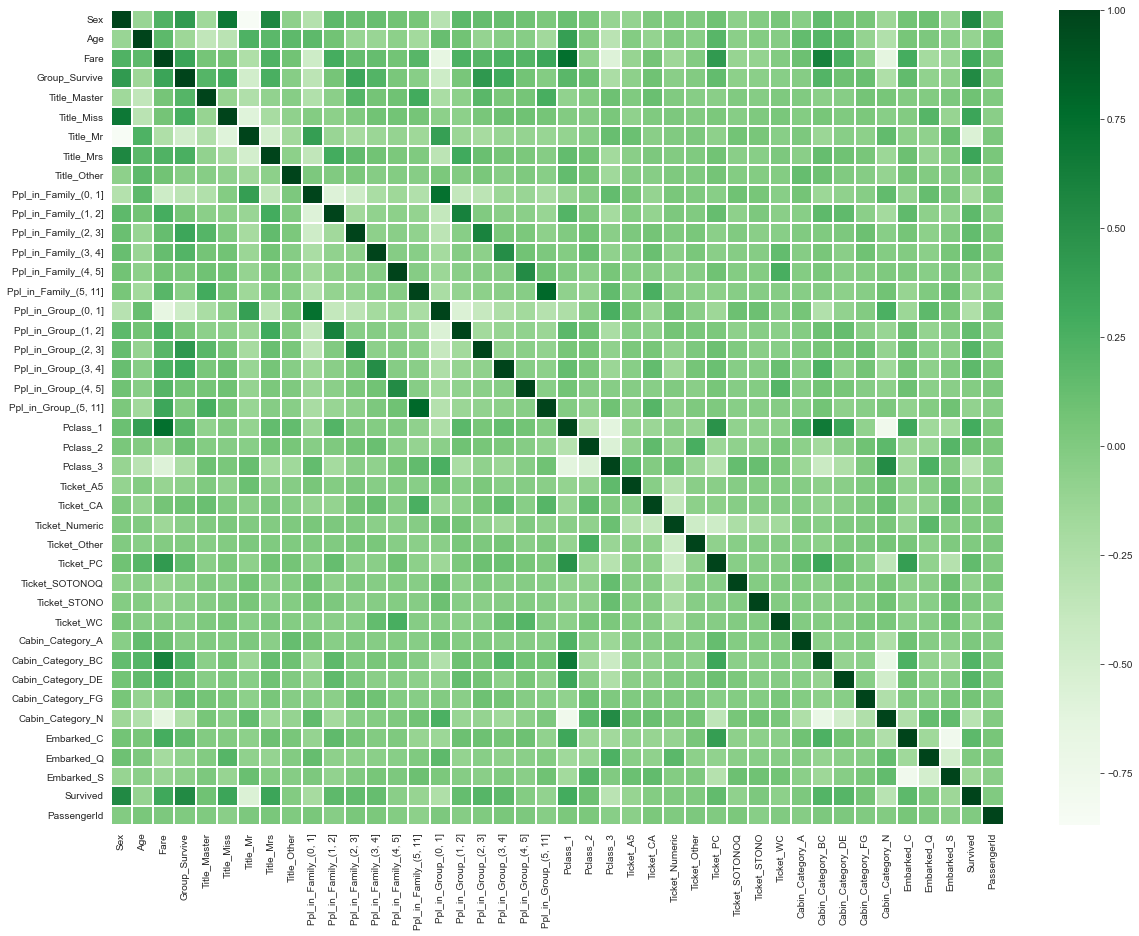

In [41]:
outlier_bound = np.sort(df_scores)[8]

df["Survived"] = df_spare.Survived
df["PassengerId"] = df_spare.PassengerId

#df_train = df.iloc[:train_bound, :][~(df_scores[:train_bound] < outlier_bound)]
df_train = df.iloc[:train_bound, :]
df_test = df.iloc[train_bound:, :]
df_train.to_csv("outputs/train.csv", index=False)
df_test.to_csv("outputs/test.csv", index=False)

plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), linewidths=2, cmap="Greens");

##  2. Train & Evaluation

In fact, what really determines the success of artificial intelligence is data. If the data is not clean enough and has not gone through efficient pre-processing steps, the success of the machine learning model is often low. If I go to the machine learning part after dealing with the data enough, there were generally 5 different machine learning models that gave me the highest success in this part. These:
* LightGBM
* XGBoost
* Random Forest Classifier
* CatBoost
* Logistic Regression

Now, output data were read from their saved locations. Grid search fit commands are commented in order to prevent missclick which may result on collapsing the kernel. However, fit commands of the models with tuned parameters are not commented to visualize results to user.

In [42]:
df_train = pd.read_csv("outputs/train.csv")
df_test = pd.read_csv("outputs/test.csv")

x, y = df_train.drop(["Survived","PassengerId"], axis=1).to_numpy(), df_train["Survived"].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1506)

## 2.1 LightGBM

In [43]:

from sklearn.model_selection import GridSearchCV
lgbm = LGBMClassifier()
params = {'num_leaves':[20,40,60,80,100],
          'min_child_samples':[5,10,15],
          'max_depth':[-1,5,10,20],
         'learning_rate':[0.01, 0.05,0.1]}
scorer = make_scorer(accuracy_score)
lgbm_grid = GridSearchCV(estimator=lgbm, param_grid=params, scoring=scorer, cv=5)

"""
lgbm_grid.fit(x, y)
lgbm_best_params = lgbm_grid.best_params_
lgbm_best_params""";

In [44]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(learning_rate=0.01, max_depth=-1, min_child_samples=10, num_leaves=20)
scores = cross_val_score(lgbm, x, y, cv=5, scoring=make_scorer(accuracy_score))
result = sum(scores) / len(scores)

with open("outputs/results.txt", "a") as f:
    result_str = "\n**********************LGBM**************************\n"
    result_str += str(result) + "---" + str(df_train.columns)
    result_str += "\n***************************************************\n"
    f.write(result_str)
result

0.8529596384407758

## 2.2 XGBoost

In [45]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
xgboost = XGBClassifier()
params = {'gamma': [0.1, 1, 10, 100],
              'learning_rate': [0.01, 0.05, 0.1],
              'max_depth': [3,4, 5,6,7,8,10],
              'n_estimators': [10, 20, 30, 40, 50,75, 100]}
scorer = make_scorer(accuracy_score)
xgb_grid = GridSearchCV(estimator=xgboost, param_grid=params, scoring=scorer, cv=5)

"""
xgb_grid.fit(x, y)
xgb_best_params = xgb_grid.best_params_
xgb_best_params""";

In [46]:
from xgboost.sklearn import XGBClassifier

xgb = XGBClassifier(eval_metric="logloss")# it was changing by itself automatically and giving warning about this change.
scores = cross_val_score(xgb, x, y, cv=5, scoring=make_scorer(accuracy_score))
result = sum(scores) / len(scores)

with open("outputs/results.txt", "a") as f:
    result_str = "\n*******************XGBoost**************************\n"
    result_str += str(result) + "---" + str(df_train.columns)
    result_str += "\n***************************************************\n"
    f.write(result_str)
result

0.8148138848785387

## 2.3 Random Forest Classifier

In [47]:
rfc = RandomForestClassifier()
params = {'max_depth': [5, 8, 10,15, 20],
    'min_samples_leaf': [1, 2, 4, 5],
    'min_samples_split': [2, 4, 5,  10],
    'n_estimators': [500, 750, 1000, 1500]}
scorer = make_scorer(accuracy_score)
rfc_grid = GridSearchCV(estimator=rfc, param_grid=params, scoring=scorer, cv=5)

"""
rfc_grid.fit(x, y)
rfc_grid_best_params = rfc_grid.best_params_
rfc_grid_best_params""";

In [48]:
rfc = RandomForestClassifier(bootstrap=True, min_samples_leaf=1, min_samples_split=10, max_depth=20, n_estimators=1000)
scores = cross_val_score(rfc, x, y, cv=5, scoring=make_scorer(accuracy_score))
result = sum(scores) / len(scores)

with open("outputs/results.txt", "a") as f:
    result_str = "\n****************Random Forest Classifier************\n"
    result_str += str(result) + "---" + str(df_train.columns)
    result_str += "\n***************************************************\n"
    f.write(result_str)
result

0.8439959826752872

## 2.4 CATBoost
If I summarize the working principle of this algorithm I use, it was developed by Yandex and is based on gradient boosted decision trees. It creates new trees sequentially during training, with each tree having less loss than the previous tree. If I had to describe the parameters I'm trying to optimize with GridSearchCV:
* **Depth:** Determines the depth of the tree and is the same for all trees.
* **Iterations:** Determines the maximum number of trees to be created.
* **Learning Rate:** It is the weight regulation coefficient against the error made.
* **l2_leaf_reg:** L2 regulation cost function coefficient.
* **leaf_estimation_method:** It is a method of calculating the values inside the leaves.

In [49]:
catboost_clf = CatBoostClassifier(verbose=0)
params = {'depth':[3, 5, 6, 7,9],
          'iterations':[250,500,1000],
          'learning_rate':[0.01, 0.03, 0.05,0.1], 
          'l2_leaf_reg':[1,3,5, 10, 100],
          "leaf_estimation_method":[None, "Newton", "Gradient"]}
scorer = make_scorer(accuracy_score)
catboost_grid = GridSearchCV(estimator=catboost_clf, param_grid=params, scoring=scorer, cv=5)

"""
catboost_grid.fit(x, y)
catboost_best_params = catboost_grid.best_params_
catboost_best_params""";

In [50]:
catboost_clf = CatBoostClassifier(depth=9, iterations=1000, l2_leaf_reg=100, learning_rate=0.01, verbose=0,
                                  leaf_estimation_method="Newton")
scores = cross_val_score(catboost_clf, x, y, cv=5, scoring=make_scorer(accuracy_score))
result = sum(scores) / len(scores)

with open("outputs/results.txt", "a") as f:
    result_str = "\n***********************CATBOOST************************\n"
    result_str += str(result) + "---" + str(df_train.columns)
    result_str += "\n***************************************************\n"
    f.write(result_str)
result
# 0.8473667691921412

0.8428786642395331

## 2.5 Logistic Regression

In [51]:
log_reg = LogisticRegression()
params = {"penalty":["l1","l2"],
          "tol":[1e-2, 1e-3,1e-4],
          "C":[1e-2, 0.1, 0.5, 1, 10, 100],
          "solver":["liblinear", "lbfgs"],
          "max_iter":[100, 250, 500, 1000]}
scorer = make_scorer(accuracy_score)
log_reg_grid = GridSearchCV(estimator=log_reg, param_grid=params, scoring=scorer, cv=5)

"""
log_reg_grid.fit(x, y)
log_reg_best_params = log_reg_grid.best_params_
log_reg_best_params""";

In [52]:
log_reg = LogisticRegression(C=1, max_iter=100, penalty="l2", solver="lbfgs", tol=0.01)
scores = cross_val_score(log_reg, x, y, cv=5, scoring=make_scorer(accuracy_score))
result = sum(scores) / len(scores)
result

with open("outputs/results.txt", "a") as f:
    result_str = "\n*************Logistic Regression********************\n"
    result_str += str(result) + "---" + str(df_train.columns)
    result_str += "\n***************************************************\n"
    f.write(result_str)
result

0.8327851358985624

## 2.6 Voting Classifier

In [53]:
rfc = RandomForestClassifier(bootstrap=True, min_samples_leaf=1, min_samples_split=10, max_depth=20, n_estimators=400).fit(x,y)
xgboost = xgboost = XGBClassifier(gamma=1, learning_rate=0.05, max_depth=8, n_estimators=400, eval_metric="logloss").fit(x,y)
catboost = CatBoostClassifier(depth=9, iterations=1000, l2_leaf_reg=100, learning_rate=0.01, verbose=0).fit(x,y)
log_reg = LogisticRegression(C=1, max_iter=100, penalty="l2", solver="lbfgs", tol=0.01).fit(x,y)
lgbm = LGBMClassifier(learning_rate=0.01, max_depth=-1, min_child_samples=10, num_leaves=20).fit(x,y)


voting_clf = VotingClassifier(estimators=[('RandomForest', rfc), ('XGBoost', xgboost),
                                   ('CATBoost', catboost), ('LGBM', lgbm), ("LOGISTIC", log_reg)], voting='hard').fit(x,y)

scores = cross_val_score(voting_clf, x, y, cv=5, scoring=make_scorer(accuracy_score))
result = sum(scores) / len(scores)

with open("outputs/results.txt", "a") as f:
    result_str = "\n*****************Voting Classifier******************\n"
    result_str += str(result) + "---" + str(df_train.columns)
    result_str += "\n***************************************************\n"
    f.write(result_str)
result

0.844002259745151

## 2.7 Feature Importance of Best Model

Feature importance indicates how much importance the trained machine learning model gives to which features when deciding on a output. Like correlation matrices, feature importance also helps us to understand the connections between features and output. Thus, we can analyze these data by understanding which outputs the machine learning model gives importance to and which does not.

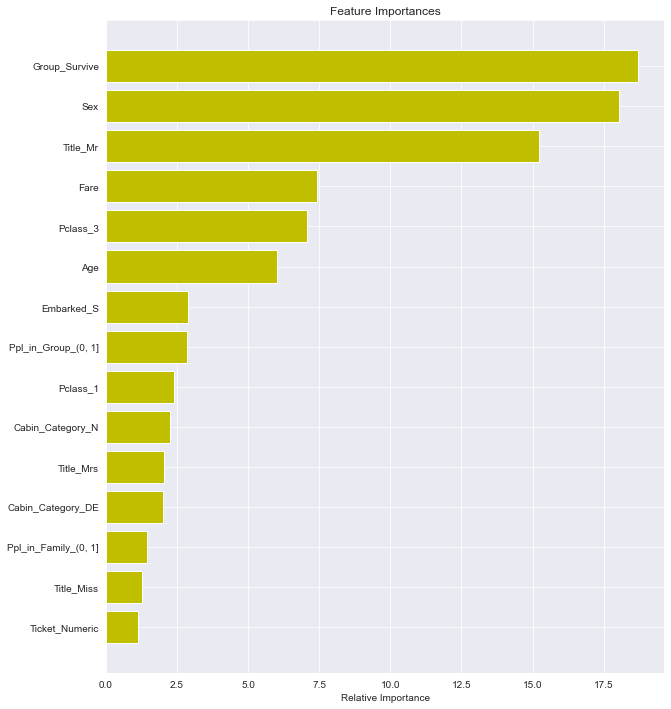

In [54]:
catboost_clf = CatBoostClassifier(depth=9, iterations=1000, l2_leaf_reg=100, learning_rate=0.01, verbose=0, 
                                 leaf_estimation_method="Newton").fit(x,y)

features = df.drop(['Survived','PassengerId'], axis=1).columns
feature_importances = catboost_clf.feature_importances_
indices = np.flip(np.flip(np.argsort(feature_importances))[:15])
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='y', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 3. Submission

After evaluating the performance of the Submission models alone and together, I got the most successful result with **CatBoost**. In this evaluation, I provided the estimation of the submission data from underfit to overfit with **StratifiedKFold**. With this module, I have been trained by subtracting 20% each time from the data set and assigned the probabilities of the predictions made as a result of that training to the columns. Finally, I took the average of these probabilities and decided whether that person was survived or not.

In [55]:
#voting_clf = VotingClassifier(estimators=[('RandomForest', rfc), ('XGBoost', xgboost),
 #                                  ('CATBoost', catboost), ('LGBM', lgbm), ("LOGISTIC", log_reg)], voting='hard')
catboost_clf = CatBoostClassifier(depth=9, iterations=1000, l2_leaf_reg=100, learning_rate=0.01, verbose=0,
                                 leaf_estimation_method="Newton")
#rfc = RandomForestClassifier(bootstrap=True, min_samples_leaf=1, min_samples_split=10, max_depth=20, n_estimators=1000)
#rfc = RandomForestClassifier(bootstrap=True, min_samples_leaf=1, min_samples_split=10, max_depth=20, n_estimators=1500)
#lgbm = LGBMClassifier(learning_rate=0.01, max_depth=-1, min_child_samples=10, num_leaves=20).fit(x,y)
#log_reg = LogisticRegression(C=1, max_iter=100, penalty="l2", solver="lbfgs", tol=0.01).fit(x,y)


stratified_kf = StratifiedKFold(n_splits=5, random_state=1506, shuffle=True)
x_submission = df_test.drop(["PassengerId", "Survived"], axis=1).to_numpy()

predictions_df = pd.DataFrame()
for i, (train_data, validation_data) in enumerate(stratified_kf.split(x, y)):
    catboost_clf.fit(x[train_data], y[train_data])
    predictions_df.loc[:, f'pred_{i}'] = catboost_clf.predict_proba(x_submission)[:, 1]

predictions_df["Prediction"] = predictions_df.apply(lambda x: 1 if (x.pred_0 + x.pred_1 + x.pred_2 + x.pred_3 + x.pred_4) / 5 >= 0.5
                                                    else 0, axis=1)

In [56]:
df_sub = pd.read_csv("datasets/gender_submission.csv")
df_sub["Survived"] = predictions_df["Prediction"]
df_sub["Survived"] = df_sub["Survived"].astype(int)
df_sub.to_csv("outputs/submission.csv", index=False)

As a result, I managed to be 323rd among 13,700 teams with an accuracy score of 0.80861 and entered 3%.